## Assistants API의 기본 요소

Assistants: 모델(GPT-3.5, GPT-4, etc), instruction(지시문/프롬프트), tools(도구), files(업로드한 파일)를 캡슐화하는 역할입니다.

Threads: 하나의 대화 채널입니다. 메시지(Message)를 담을 수 있으며, ChatGPT 기준 하나의 대화 스레드의 개념으로 생각하면 됩니다.

Runs: Assistant + Thread 에서의 실행을 구동합니다. Run 단계에서 tools(도구) 의 활용 여부가 결정되기도 합니다. 또한, Run 을 수행한 후 Assistant 가 응답한 결과를 처리할 때도 사용할 수 있습니다.


In [1]:
# openai 라이브러리를 최신 버전으로 업그레이드하여 설치합니다.
! pip install --upgrade openai -q
! pip install python-dotenv

In [2]:
import json
# 인자로 받은 객체의 모델을 JSON 형태로 변환하여 출력합니다.
# Assistant 가 응답한 결과를 분석할 때 답변을 출력(print)할 목적으로 활용하는 함수입니다.

def show_json(obj):
    # obj의 모델을 JSON 형태로 변환한 후 출력합니다.
    display(json.loads(obj.model_dump_json()))

In [3]:
# API_KEY 설정

from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
import os
from openai import OpenAI

# os.environ["OPENAI_API_KEY"] = "API KEY를 입력해 주세요"
# OPENAI_API_KEY 를 설정합니다.
api_key = os.environ.get("OPENAI_API_KEY")
print(api_key)

# OpenAI API를 사용하기 위한 클라이언트 객체를 생성합니다.
client = OpenAI(api_key=api_key)

In [ ]:
# 수학 과외 선생님 역할을 하는 챗봇을 생성합니다.
# 이 챗봇은 간단한 문장이나 한 문장으로 질문에 답변합니다.
assistant = client.beta.assistants.create(
    name="Math Tutor",
    instructions="You are a personal math tutor. Answer questions briefly, in a sentence or less.",
    model="gpt-4-turbo-preview",
)
# 생성된 챗봇의 정보를 JSON 형태로 출력합니다.
show_json(assistant)

In [ ]:
ASSISTANT_ID = assistant.id
print(f"[생성한 Assistants ID]\n{ASSISTANT_ID}")

In [ ]:
# 새로운 스레드를 생성합니다.
thread = client.beta.threads.create()

# 생성된 스레드의 정보를 JSON 형식으로 출력합니다.
show_json(thread)

In [ ]:
# 생성된 thread에 message 추가

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="다음의 방정식을 풀고 싶습니다. `3x + 11 = 14`. 수학선생님 도와주실 수 있나요?",
)
show_json(message)


## RUN
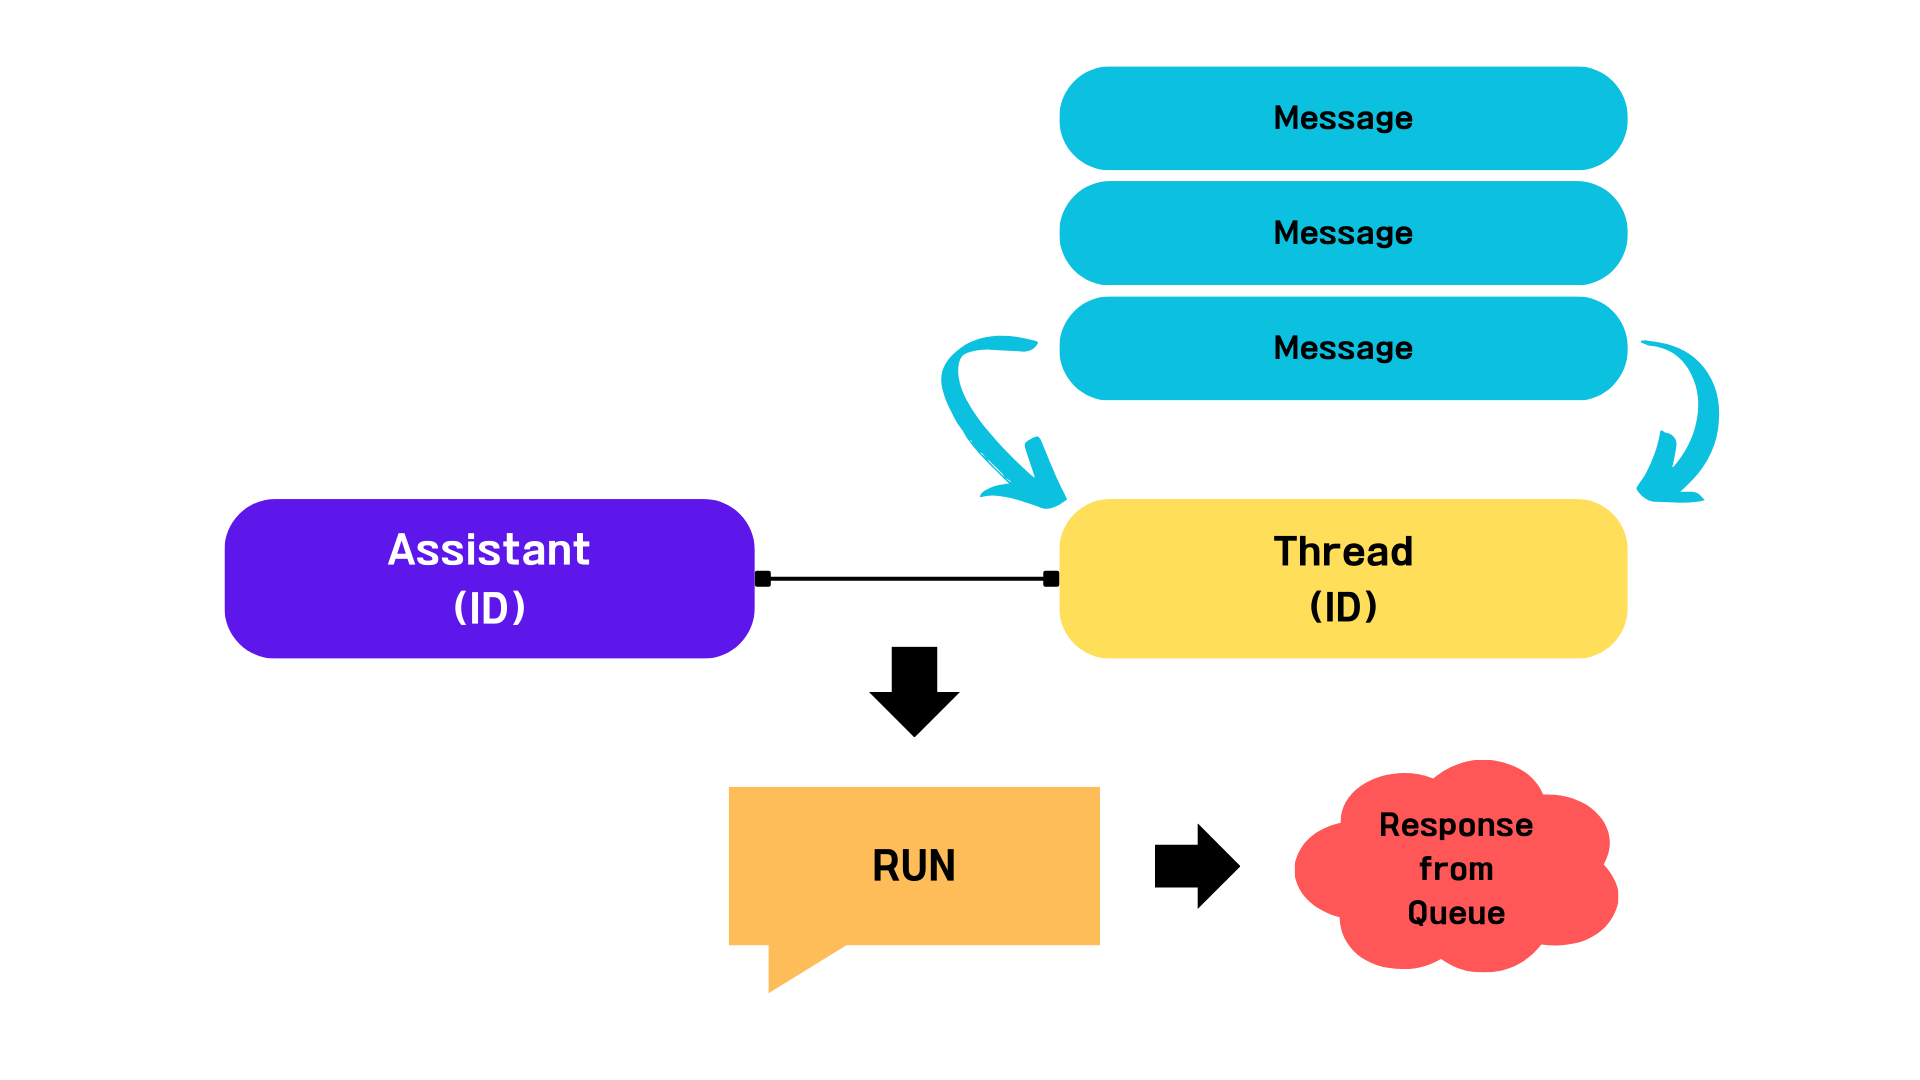


In [ ]:
# Run을 생성하면 Assistant 에게 Thread 에 들어있는 Message 목록을 살펴보고 조치를 취하라는 지시를 합니다. 
# 여기서 조치는 단일 텍스트 응답(일반 채팅) 일 수도 있고, tools(도구) 사용일 수도 있습니다.
# 사용자에게 응답하도록 Assistant를 활성화하려면 Run을 생성합시다.

# 실행할 Run 을 생성합니다.
# Thread ID 와 Assistant ID 를 지정합니다.
run = client.beta.threads.runs.create(
    thread_id=thread.id,  # 생성한 스레드 ID
    assistant_id=assistant.id,  # 적용할 Assistant ID
)
show_json(run)

## Run을 생성하는 것은 비동기 작업입니다.

이는 Run의 메타데이터와 함께 즉시 반환되며, status 는 queued(대기중) 으로 표기됩니다.

status는 Assistant가 작업을 수행함에 따라(도구 사용 및 메시지 추가와 같은) 업데이트될 것입니다. 상태 값은 아래의 목록을 참고하세요.

status 목록

    queued: 아직 실행이 되지 않고 대기중인 상태
    in_progress: 처리중
    requires_action: 사용자 입력 대기중
    cancelling: 작업 취소중
    cancelled: 작업 취소 완료
    failed: 실패(오류)
    completed: 작업 완료
    expired: 작업 만료

Assistant가 처리를 완료했는지 알기 위해서는 Run을 반복해서 폴링할 수 있습니다. (OpenAI 는 곧 실시간 스트리밍 지원이 곧 제공될 예정이라고 합니다!)

In [10]:
# Run 의 status(상태) 를 폴링하면서 주기적으로 확인하는 코드입니다.
# 주기적으로 확인하면서 status 가 completed 될 때까지 기다립니다.

import time  

def wait_on_run(run, thread):  # run, thread object value
    # 주어진 실행(run)이 완료될 때까지 대기합니다.
    # status 가 "queued" 또는 "in_progress" 인 경우에는 계속 polling 하며 대기합니다.
    while run.status == "queued" or run.status == "in_progress":
        # run.status 를 업데이트합니다.
        run = client.beta.threads.runs.retrieve(
            thread_id=thread.id,
            run_id=run.id,
        )
        # API 요청 사이에 잠깐의 대기 시간을 두어 서버 부하를 줄입니다.
        time.sleep(0.5) # 0.5 초 cpu sleeptime 설정 (delay 효과)
    return run

In [ ]:
# run 객체를 대기 상태로 설정하고, 해당 스레드에서 실행을 완료할 때까지 기다립니다.
run = wait_on_run(run, thread)

# status 가 "complete" 인 경우에는 결과를 출력합니다.
show_json(run)

In [ ]:
# Message : Run이 완료되었으므로, Assistant에 의해 처리된 결과를 보기 위해 Thread에서 Messages를 확인할 수 있습니다.

# thread.id를 사용하여 메시지 목록을 가져옵니다.
messages = client.beta.threads.messages.list(thread_id=thread.id)

# 결과를 출력합니다.
show_json(messages)

In [ ]:
# 이전에 받은 답변이 단답형 답변이라서, 조금 더 자세히 설명해 달라고 요청해 보겠습니다(이전의 대화내용을 기억하고 있는지 확인해 보기 위함입니다).

# 스레드에 추가할 메시지 생성
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="설명이 잘 이해가 가지 않습니다. 좀 더 자세히 설명해 주실 수 있나요?",
)

# 실행을 시작함
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
)

# 완료될 때까지 대기
wait_on_run(run, thread)

# 마지막 사용자 메시지 이후에 추가된 모든 메시지를 검색
messages = client.beta.threads.messages.list(
    thread_id=thread.id, order="asc", after=message.id
)
show_json(messages)

## 다시 한 번 정리 하자면 다음과 같습니다.

    1. Asssitant 생성. Assistant 의 역할 부여.

    2. 새로운 Thread 생성. 해당 Thread 에 Message 추가.

    3. Message 생성. Message 생성시 Thread 의 ID 를 입력하여 Message 추가

    4. Run 생성. Run을 수행할 Assistant 와 실행할 Thread ID 를 지정 후 Run 실행

In [16]:
from functions import *

thread_id=thread.id,  # 생성한 스레드 ID
assistant_id=assistant.id

# 동시에 여러 요청을 처리하기 위해 스레드를 생성합니다.
thread1, run1 = create_thread_and_run(
    "다음 방정식을 풀고 싶습니다. `3x + 11 = 14`. 좀 도와주실 수 있나요?",
    assistant_id
)
thread2, run2 = create_thread_and_run("선형대수에 대해 간략히 설명해 주실 수 있나요?",
    assistant_id)
thread3, run3 = create_thread_and_run(
    "수학에 정말 소질이 없는 것 같아요. 어떻게 하면 수학을 잘할 수 있을까요?",
    assistant_id)


In [17]:
# 메시지 출력용 함수
def print_message(response):
    for res in response:
        print(f"[{res.role.upper()}]\n{res.content[0].text.value}\n")
    print("---" * 20)
    
# 첫 번째 실행을 위해 대기
run1 = wait_on_run(run1, thread1)
print_message(get_response(thread1))

# 두 번째 실행을 위해 대기
run2 = wait_on_run(run2, thread2)
print_message(get_response(thread2))

# 세 번째 실행을 위해 대기
run3 = wait_on_run(run3, thread3)
# 세 번째 스레드를 마치면 감사 인사를 전하고 종료합니다 :)
run4 = submit_message(ASSISTANT_ID, thread3, "도와주셔서 감사합니다!")
run4 = wait_on_run(run4, thread3)
print_message(get_response(thread3))

[USER]
다음 방정식을 풀고 싶습니다. `3x + 11 = 14`. 좀 도와주실 수 있나요?

[ASSISTANT]
네, 방정식 `3x + 11 = 14`를 푸는 방법은 다음과 같습니다: 먼저 양변에서 11을 빼서 `3x = 3`을 얻고, 그 후 양변을 3으로 나누어 `x = 1`을 얻습니다.

------------------------------------------------------------
[USER]
선형대수에 대해 간략히 설명해 주실 수 있나요?

[ASSISTANT]
선형대수는 벡터, 행렬, 벡터 공간 같은 개념을 다루는 수학의 한 분야입니다.

------------------------------------------------------------
[USER]
수학에 정말 소질이 없는 것 같아요. 어떻게 하면 수학을 잘할 수 있을까요?

[ASSISTANT]
수학을 잘하기 위해서는 기본 개념을 충분히 이해하고, 많은 연습 문제를 풀어보며, 실수에서 배우는 태도가 중요합니다.

[USER]
도와주셔서 감사합니다!

[ASSISTANT]
언제든지 환영입니다! 도움이 필요하시면 언제든지 질문해주세요.

------------------------------------------------------------


In [23]:
# 스레드를 새롭게 생성합니다.
def create_new_thread():
    # 새로운 스레드를 생성합니다.
    thread = client.beta.threads.create()
    return thread

In [25]:
def ask(assistant_id, thread_id, user_message):
    run = submit_message(
        assistant_id,
        thread_id,
        user_message,
    )
    # 실행이 완료될 때까지 대기합니다.
    run = wait_on_run(run, thread_id)
    print_message(get_response(thread_id).data[-2:])
    return run

In [ ]:

# thread_id = "기존 스레드 ID를 입력해 주세요"
thread_id = create_new_thread().id # 새로운 스레드를 생성합니다.
print(assistant_id, thread_id)
run = ask(assistant_id, thread,  # thread is object, not string
          "I need to solve `1 + 20`. Can you help me?")

In [34]:
# 전체 대화내용 출력
print_message(get_response(thread).data[:])  # thread is object

[USER]
다음의 방정식을 풀고 싶습니다. `3x + 11 = 14`. 수학선생님 도와주실 수 있나요?

[ASSISTANT]
물론이죠, 방정식 `3x + 11 = 14`를 풀기 위해서, 양변에서 11을 빼서 `3x = 3`을 얻고, 양변을 3으로 나누어 `x = 1`을 얻습니다.

[USER]
설명이 잘 이해가 가지 않습니다. 좀 더 자세히 설명해 주실 수 있나요?

[ASSISTANT]
물론입니다. 방정식을 푸는 단계들을 자세히 설명하겠습니다:

1. 원래의 방정식은 `3x + 11 = 14`입니다.
2. 우선, 양변에서 11을 빼서 방정식의 양변을 균형있게 만듭니다: `3x + 11 - 11 = 14 - 11`이 되므로, `3x = 3`입니다.
3. 다음으로, `3x = 3`의 양변을 3으로 나누어 x에 대해 풉니다: `3x / 3 = 3 / 3`, 따라서 `x = 1`이 됩니다.

즉, x의 값을 찾는 과정에서 우선 방정식의 한 쪽에서 11을 제거하여 단순화시키고, 그 다음으로 3으로 나누어 x의 값을 구합니다. 결과적으로, `x = 1`이 이 방정식의 해가 됩니다.

[USER]
I need to solve `1 + 20`. Can you help me?

[USER]
I need to solve `1 + 20`. Can you help me?

[ASSISTANT]
Yes, `1 + 20` equals `21`.

------------------------------------------------------------
